In [7]:
from DiscEvolution.grid import Grid
from DiscEvolution.star import SimpleStar
from DiscEvolution.dust import DustGrowthTwoPop, SingleFluidDrift, FixedSizeDust
from DiscEvolution.eos import SimpleDiscEOS, ChambersEOS, LocallyIsothermalEOS, IrradiatedEOS
from DiscEvolution.viscous_evolution import LBP_Solution, ViscousEvolutionFV, ViscousEvolution
from DiscEvolution.disc_winds import DiskWindEvolution
from DiscEvolution.planet_formation import *
from DiscEvolution.constants import Msun, AU, yr, Mearth

import numpy as np
import matplotlib.pyplot as plt
import copy

%config InlineBackend.figure_format = 'svg'

In [8]:
def chambers_model(param_type = "Chambers", **kwargs):

    init_params = {"sigma0":3450,
                "r0":1, 
                "T0":150, 
                "v0":30,
                "fw":0,
                "K":0, 
                "alpha_turb":0,
                "alpha_wind":0,
                "Tevap":1500, 
                "rexp":15,
                "k0":0.1,
                "rmin":0.05,
                "rmax":1000,
                "nr":1000,
                "initial_frac":0.01,
                "fixed_size":False,
                "init_conditions": False,
                "feedback": True}
    
    alpha_turb = init_params['alpha_turb']

    init_params.update(kwargs)

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar(M=1, R=2.5, T_eff = 4000)
    wind = DiskWindEvolution(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])
    
    eos = ChambersEOS(star, init_params['sigma0'],init_params['r0'],init_params['T0'],
                            init_params['v0'],init_params['fw'],
                            init_params['K'],init_params['Tevap'],
                            init_params['rexp'],init_params['k0'])

    if param_type == "Suzuki":
        wind.calculate_chambers_params(init_params['alpha_turb'], init_params['alpha_wind'], set=True)
        # eos = LocallyIsothermalEOS(star, 1/30., -0.25, init_params['alpha_turb'])
        eos.update_params(wind)
    else:
        pass

    eos.set_grid(grid)
    
    Sigma = wind(0, grid.Rc)
    Mdot = wind.M_acc
    Mtot = wind.M_tot
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma, feedback = init_params['feedback'])


    return disc, grid, eos, wind

In [9]:
def LBP_model(**kwargs):

    init_params = {"alpha":1e-3, "rmin":0.05, "rmax":1000, "nr":1000, "Mdot":1e-8, "Rd":30}
    init_params.update(kwargs)

    alpha = init_params['alpha']

    grid = Grid(init_params['rmin'], init_params['rmax'], init_params['nr'])
    star = SimpleStar()

    Mdot  = init_params["Mdot"]
    Rd    = init_params["Rd"]
    R = grid.Rc
    Mdot *= (Msun / yr) / AU**2
    Sigma = (Mdot / (0.1 * alpha * R**2 * star.Omega_k(R))) * np.exp(-R/Rd)

    eos = SimpleDiscEOS(star, alpha)    
    eos.set_grid(grid)
    eos.update(0, Sigma)
    for i in range(100):
        Sigma = 0.5 * (Sigma + (Mdot / (3 * np.pi * eos.nu)) * np.exp(-R/Rd))
        eos.update(0, Sigma)

    gas = ViscousEvolution()
    
    disc = DustGrowthTwoPop(grid, star, eos, 0.01, Sigma)
    
    v_visc = gas.viscous_velocity(disc, Sigma)
    Mdot = disc.Mdot(v_visc)[0]
    Mtot = disc.Mtot()/Msun

    return disc, grid, eos, gas, Mdot, Mtot

<>:23: SyntaxWarning: invalid escape sequence '\S'
<>:23: SyntaxWarning: invalid escape sequence '\S'
/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_38943/3489399070.py:23: SyntaxWarning: invalid escape sequence '\S'
  ax[0].set_ylabel("Surface density $\Sigma_g$ [g cm$^{-3}$]", size=13)
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/eos.py:641: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/eos.py:222: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1


Chambers accretion rate: 1.504651187990737e-09 Msun/yr. Total mass: 0.05551554414010409 Msun
LBP accretion rate: 9.824148695110857e-09 Msun/yr. Total mass: 0.04313052365015169 Msun


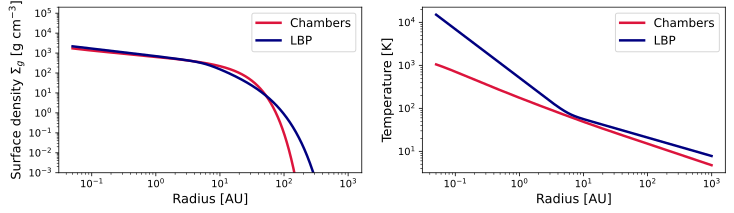

In [10]:
disc_C, grid_C, eos_C, gas_C = chambers_model(param_type="Suzuki", sigma0=300, rexp = 95, alpha_turb=1e-3, alpha_wind=0, feedback = True)
disc_C, grid_C, eos_C, gas_C = chambers_model(param_type="Suzuki", sigma0=700, rexp = 20, alpha_turb=1e-3, alpha_wind=2.5e-4, K=0.5, feedback = True)

disc_LBP, grid_LBP, eos_LBP, gas_LBP, Mdot_LBP, Mtot_LBP = LBP_model(alpha=1e-3, Mdot=1e-8, Rd=33)
v_visc_C = gas_C.viscous_velocity(disc_C)
# Mdot_C = gas_C.M_acc
# Mtot_C = gas_C.M_tot
Mdot_C = disc_C.Mdot(v_visc_C)[0]
Mtot_C = disc_C.Mtot()/Msun

Sigma_LBP = disc_LBP.Sigma_G
Rc_LBP = grid_LBP.Rc
T_LBP = disc_LBP.T
Sigma_C = disc_C.Sigma_G
T_C = disc_C.T
Rc_C = grid_C.Rc
fig, ax = plt.subplots(1,2, figsize = (12,3))
linewidth = 2.5
ax[0].loglog(Rc_C, Sigma_C, label = "Chambers", color = "Crimson", linewidth = linewidth)
ax[0].loglog(Rc_LBP, Sigma_LBP, label = "LBP", color = "navy", linewidth = linewidth)
ax[0].set_ylim(1e-3, 2e5)
ax[0].set_xlabel("Radius [AU]", size=13)
ax[0].set_ylabel("Surface density $\Sigma_g$ [g cm$^{-3}$]", size=13)
ax[0].legend(fontsize = 12)

ax[1].loglog(Rc_C, T_C, label = "Chambers", color = "crimson", linewidth = linewidth)
ax[1].loglog(Rc_LBP, T_LBP, label = "LBP", color = "navy", linewidth = linewidth)
ax[1].set_xlabel("Radius [AU]", size=13)
ax[1].set_ylabel("Temperature [K]", size=13)
ax[1].legend(fontsize = 12)

print("Chambers accretion rate:", Mdot_C, "Msun/yr.", "Total mass:", Mtot_C, "Msun")
print("LBP accretion rate:", Mdot_LBP, "Msun/yr.", "Total mass:", Mtot_LBP, "Msun")
plt.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/LBP_chambers_comparison.pdf", bbox_inches="tight")

In [12]:
dust = SingleFluidDrift(settling=False)
# gas_C.max_timestep(disc_C)

v_visc_C = gas_C.viscous_velocity(disc_C)
v_visc_LBP = gas_LBP.viscous_velocity(disc_C)

dt = dust.max_timestep(disc_C, v_visc_C)
t=0
dust(dt, disc_C, v_visc=v_visc_C)
Sigma = gas_C(dt, grid_C.Rc)
disc_C.set_surface_density(Sigma)
disc_C.update(dt)

dt = dust.max_timestep(disc_LBP, v_visc_LBP)
dust(dt, disc_LBP, v_visc=v_visc_LBP)
gas_LBP(dt, disc_LBP)
disc_LBP.update(dt)

v_visc_C = gas_C.viscous_velocity(disc_C)
v_visc_LBP = gas_LBP.viscous_velocity(disc_C)

print(dust.max_timestep(disc_C, v_visc_C), dust.max_timestep(disc_LBP))
print("deltaV:", np.mean(dust._compute_deltaV(disc_C, v_visc_C)), np.mean(dust._compute_deltaV(disc_LBP, v_visc_LBP)))


print("nu:", np.mean(disc_C.nu), np.mean(disc_LBP.nu))
print("cs:", np.mean(disc_C.cs), np.mean(disc_LBP.cs))
print("T:", np.mean(disc_C.T), np.mean(disc_LBP.T))
print("H:", np.mean(disc_C.H), np.mean(disc_LBP.H))

23.487176872975528 16.703834700522673
deltaV: -0.0001204428700200915 -0.00018470903631058168
nu: 7.536142855163642e-05 9.366440369577912e-05
cs: 0.021307103110876562 0.046475410867170185
T: 181.28133203061722 1364.0851368004521
H: 11.096132719092807 13.890085239174361


/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/eos.py:641: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1
/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/Research/Planet Formation/DiscEvolution/DiscEvolution/eos.py:222: RuntimeWarning: divide by zero encountered in divide
  return 1. / Pr_1


ValueError: x and y must have same first dimension, but have shapes (1000,) and (1,)

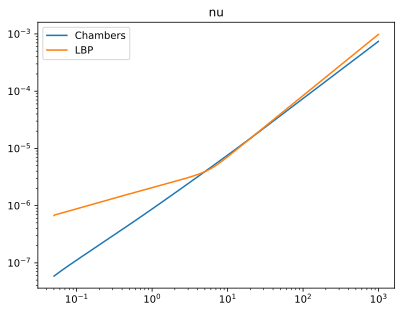

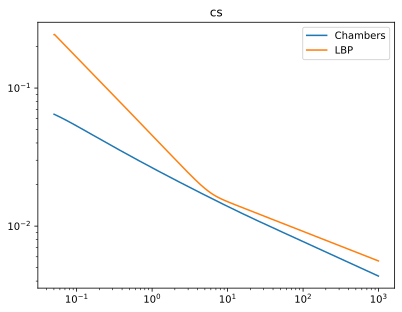

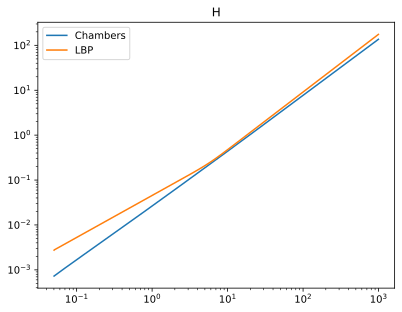

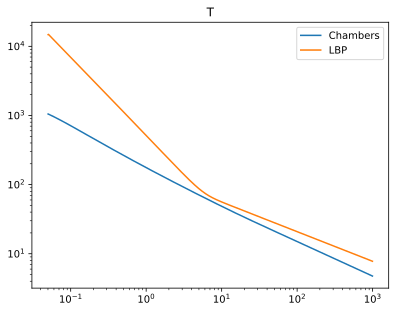

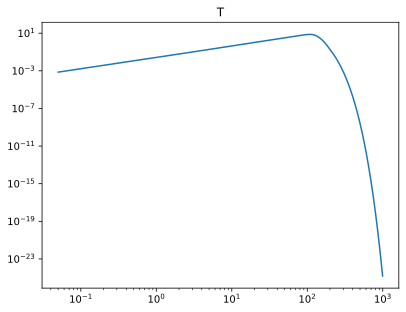

In [14]:
fig, ax = plt.subplots(1,1)
ax.set_title("nu")
ax.loglog(disc_C.R, disc_C.nu, label = "Chambers")
ax.loglog(disc_LBP.R, disc_LBP.nu, label = "LBP")
ax.legend()

fig, ax = plt.subplots(1,1)
ax.set_title("cs")
ax.loglog(disc_C.R, disc_C.cs, label = "Chambers")
ax.loglog(disc_LBP.R, disc_LBP.cs, label = "LBP")
ax.legend()

fig, ax = plt.subplots(1,1)
ax.set_title("H")
ax.loglog(disc_C.R, disc_C.H, label = "Chambers")
ax.loglog(disc_LBP.R, disc_LBP.H, label = "LBP")
ax.legend()

fig, ax = plt.subplots(1,1)
ax.set_title("T")
ax.loglog(disc_C.R, disc_C.T, label = "Chambers")
ax.loglog(disc_LBP.R, disc_LBP.T, label = "LBP")
ax.legend()

fig, ax = plt.subplots(1,1)
ax.set_title("T")
ax.loglog(disc_C.R, disc_C.Hp[0], label = "Chambers")
ax.loglog(disc_LBP.R, disc_LBP.H[0], label = "LBP")
ax.legend()

In [ ]:
def evolve(disc, gas, timesteps=[1e6], print_time = False, grow_planet = False, migrate = True):
    dust = SingleFluidDrift(van_leer=True)
    planets = Planets()
    for R in [0.1, 1, 5]:
        planets.add_planet(0, R, 0.01, 0)
    planet_model = Bitsch2015Model(disc, migrate=migrate)
    discs = []

    num_planets = 3
    core_mass = [[] for _ in range(num_planets)]
    env_mass = [[] for _ in range(num_planets)]
    growth_time = [[] for _ in range(num_planets)]
    
    times = timesteps*2*np.pi
    t=0
    n=0
    for ti in times:
        while t < ti:
            v_visc = gas.viscous_velocity(disc)
            dt = dust.max_timestep(disc, v_visc)
            # print(dt)
            dti = min(dt, ti - t)
            t = min(t + dt, ti)
            
            dust(dti, disc, v_visc=v_visc)
            gas(dt, disc)

            if grow_planet:
                planet_model.integrate(dt, planets) 

            for i, planet in enumerate(planets):
                core_mass[i].append(planet.M_core)
                env_mass[i].append(planet.M_env)
                growth_time[i].append(t)

            disc.update(dt)

            n+=1

            if print_time:
                if (n % 1000) == 0:
                    print('Nstep: {}'.format(n))
                    print('Time: {} yr'.format(t / (2 * np.pi)))
                    print('dt: {} yr'.format(dti / (2 * np.pi)))

        # return an array of disks at each time step
        discs.append(copy.deepcopy(disc))
    
    if grow_planet:
        return discs, planets, core_mass, env_mass, growth_time
    else:
        return discs

fixed = False
# timesteps = np.array([0.01, 0.1, 0.5, 0.8, 1])*1e6
timesteps = np.array([0.01, 0.1, 1, 2, 3])*1e6
# disc, grid, eos, gas = chambers_model(param_type="Suzuki", sigma0=1850, alpha_turb=1e-3, alpha_wind=0)
disc, grid, eos, gas = chambers_model(param_type="Suzuki", sigma0=1000, alpha_turb=1e-3, K=0, feedback = True)
# disc, grid, eos, gas = chambers_model(sigma0=1200, fw=0.99, K=0.1, v0=24)
# disc, grid, eos, gas = chambers_model(param_type="Suzuki", sigma0=2000, alpha_turb=5e-3, alpha_wind=0)

discs = evolve(disc, gas, timesteps = timesteps, print_time=True)
# discs, planets_out, cores, envs, growth_times = evolve(disc, gas, timesteps = timesteps, print_time=True, grow_planet=True, migrate=False)

Nstep: 1000
Time: 2240.7396954974784 yr
dt: 2.108398254815905 yr
Nstep: 2000
Time: 4238.001186360193 yr
dt: 1.8959055982940443 yr
Nstep: 3000
Time: 6049.67511589931 yr
dt: 1.7351313040960243 yr
Nstep: 4000
Time: 7720.9074868746375 yr
dt: 1.6128029928601513 yr
Nstep: 5000
Time: 9284.175822669213 yr
dt: 1.5176074233218098 yr
Nstep: 6000
Time: 10762.199323580122 yr
dt: 1.4417741682003868 yr
Nstep: 7000
Time: 12172.082520738388 yr
dt: 1.3800853745958797 yr
Nstep: 8000
Time: 13525.866219694417 yr
dt: 1.329088422255229 yr
Nstep: 9000
Time: 14817.352690147221 yr
dt: 1.3009582996366371 yr
Nstep: 10000
Time: 16047.640454688846 yr
dt: 1.2321337497049647 yr
Nstep: 11000
Time: 17213.719642544478 yr
dt: 1.092884002025203 yr
Nstep: 12000
Time: 18317.052288303123 yr
dt: 1.056671594911248 yr
Nstep: 13000
Time: 19368.239229590363 yr
dt: 1.0536082110475673 yr
Nstep: 14000
Time: 20375.77380018142 yr
dt: 1.0010209539012354 yr
Nstep: 15000
Time: 21348.202924047328 yr
dt: 0.9364338671642041 yr
Nstep: 16000


[2.11769997e-08]
2.1176999743018424e-08
[1.10213428e-06]
1.1021342842809226e-06
[1.03516065e-06]
1.0351606537807284e-06
[1.17807275e-06]
1.1780727534821055e-06
[1.31973864e-06]
1.3197386379324949e-06
[1.44448964e-06]
1.4444896394709756e-06
[1.55269559e-06]
1.5526955902995584e-06
[1.64650216e-06]
1.6465021586944468e-06
[1.72790439e-06]
1.727904393671231e-06
[1.79857549e-06]
1.7985754948619535e-06
[1.85987953e-06]
1.8598795291873992e-06
[1.9131497e-06]
1.913149701614674e-06
[1.95921208e-06]
1.9592120828048374e-06
[1.99897479e-06]
1.998974790024955e-06
[2.03312705e-06]
2.0331270535595367e-06
[2.06234494e-06]
2.0623449393366043e-06
[2.0871358e-06]
2.0871357961788008e-06
[2.10798615e-06]
2.10798615323314e-06
[2.12526276e-06]
2.1252627632523437e-06
[2.13944023e-06]
2.1394402326563015e-06
[2.15072607e-06]
2.150726072506269e-06
[2.15947224e-06]
2.1594722354725504e-06
[2.16590294e-06]
2.1659029371879852e-06
[2.17024727e-06]
2.1702472689312326e-06
[2.17270788e-06]
2.172707876860826e-06
[2.173518

/var/folders/80/3_r0dytx0g58z7ybrd36jc_40000gn/T/ipykernel_72030/4053246265.py:38: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 200)


Error in callback <function _draw_all_if_interactive at 0x1668d2480> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

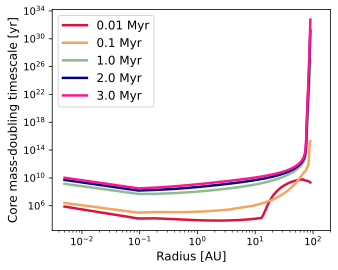

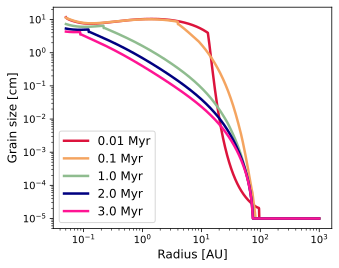

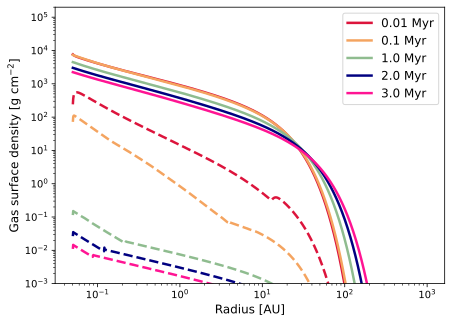

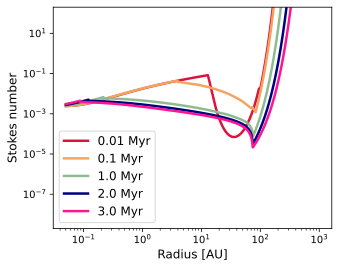

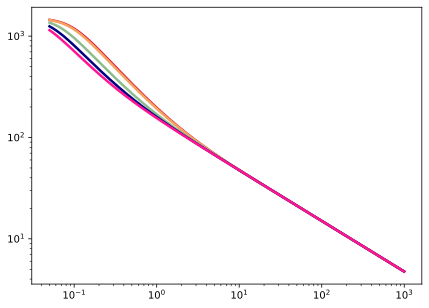

In [ ]:
R = np.linspace(0.005, 90, 1000)

fig, ax = plt.subplots(1,1, figsize = (5,4))
fig2, ax2 = plt.subplots(1,1, figsize = (5,4))
# fig3, ax3 = plt.subplots(1,1, figsize = (8,6))
fig4, ax4 = plt.subplots(1,1, figsize = (7,5))
fig5, ax5 = plt.subplots(1,1, figsize = (5,4))
fig6, ax6= plt.subplots(1,1, figsize = (7,5))
t0 = 2*np.pi
M = 0.1
i=0
colours = ["crimson", "sandybrown", "darkseagreen", "navy", "deeppink", "darkorange"]
for disc, t in zip(discs, timesteps):
    times = []
    Rs = []
    for R_p in R:
        planets = Planets(Nchem = 0)
        planets.add_planet(t, R_p, M, 0.001)
        PebAcc = PebbleAccretionHill(disc)
        M_dot = PebAcc(planets)
        print(M_dot)
        print(M_dot[0])

        M_core = M
        core_time = M_core/M_dot/t0

        times.append(core_time)
        Rs.append(R_p)

    ax6.loglog(disc.R, disc.T, label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax5.loglog(disc.R, disc.Stokes()[1], label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax4.loglog(disc.R, disc.Sigma_G, label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax4.loglog(disc.R, disc.Sigma_D[1], color = colours[i], linestyle = "--", linewidth = linewidth)
    ax2.loglog(disc.R, disc.grain_size[1], label = f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    ax.loglog(R, times, label=f"{t/1e6} Myr", color = colours[i], linewidth = linewidth)
    i+=1
    
ax.set_xlim(0, 200)
ax.set_xlabel("Radius [AU]", size = 12)
ax.set_ylabel("Core mass-doubling timescale [yr]", size = 12)
ax.legend(fontsize = 12)

# ax2.set_xlim(0, 200)
# ax2.set_ylim(1e-12, 10)
ax2.set_xlabel("Radius [AU]", size = 12)
ax2.set_ylabel("Grain size [cm]", size = 12)
ax2.legend(fontsize = 12)

# ax3.set_xlabel("Radius [AU]")
# ax3.set_ylabel(r"Dust surface density [g cm$^{2}$]")
# ax3.set_ylim(1e-5, 2e5)
# ax3.legend()

ax4.set_xlabel("Radius [AU]", size = 12)
ax4.set_ylabel(r"Gas surface density [g cm$^{-2}$]", size = 12)
ax4.set_ylim(1e-3, 2e5)
ax4.legend(fontsize = 12)

ax5.set_xlabel("Radius [AU]", size = 12)
ax5.set_ylabel("Stokes number", size = 12)
ax5.set_ylim(top=2e2)
ax5.legend(fontsize = 12)

In [ ]:
# fig.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/planet_growth_timescales.pdf", bbox_inches="tight")
# fig4.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/viscous_disk.pdf", bbox_inches="tight")
# fig5.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/stokes_numbers.pdf", bbox_inches="tight")
# fig2.savefig("/Users/safwankhan/Library/CloudStorage/OneDrive-UniversityofWaterloo/University/4B/PHYS 437B/Presentation/figures/pebble_size.pdf", bbox_inches="tight")

NameError: name 'growth_times' is not defined

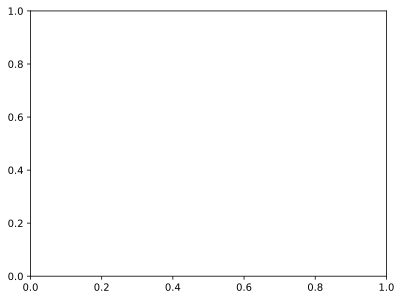

In [ ]:
labels = {0: "0.1 AU",
          1: "1 AU",
          2: "5 AU"}

fig, ax = plt.subplots(1,1)
for i in [0,1,2]:
    ax.loglog(growth_times[i], cores[i], label = labels[i], color = colours[i], linewidth=2)
    ax.loglog(growth_times[i], envs[i], color = colours[i], linestyle = "--", linewidth=2)
ax.legend()
ax.set_xlabel("Time [yr]")
ax.set_ylabel(r"Mass [$M_{\oplus}$]")